In [1]:
pip install scikit-posthocs

Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install holidays

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import holidays
import warnings
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from scipy.stats import kruskal
from scikit_posthocs import posthoc_nemenyi
from statsmodels.stats.multitest import multipletests


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Ignore all warnings
warnings.filterwarnings("ignore")

/kaggle/input/iyzico-datathon/sample_submission.csv
/kaggle/input/iyzico-datathon/train.csv


**Train ve Test Veri Setleri**

- **merchant_id** Maskelenmiş iş yeri ID'si
- **month_id** İşlemin yapıldığı ay (YYYYMM formatında)
- **merchant_source** İş yerinin iyzico’ya katıldığı kaynak
- **settlement_period** İş yerinin hak edişini alış sıklığı
- **working_type** İş yerinin tipini gösterir
- **mcc_id** İş yerinin satış yaptığı kategori bilgisini gösterir
- **merchant_segment** İş yerinin iyzico içerisinde bulunduğu segmenti gösterir
- **net_payment_count** İş yerinin ilgili ay içerisinde geçirdiği net (ödeme - iptal - iade) işlem sayısıdır

# CONFIGURATION

In [4]:
class config:
    dir_train = "/kaggle/input/iyzico-datathon/train.csv"
    dir_sub = "/kaggle/input/iyzico-datathon/sample_submission.csv"
    add_cumsum_merchant_id = True
    add_monthly_inflation_data = True
    add_holidays = False
    add_count_ofbreak_oniyzico = True
    add_monthly_average_temperature_values = True
    add_is_once_insysyem = False
    add_quarter = False
    add_seasonality_feature = False
    add_oil_prices = True
    add_lag_fetures = False
    add_roll_mean_features = True
    add_ewm_features = False
    add_statisctic_metrics = True
    add_quantiles = False
    add_frequences = True
    add_payU_stock = True
    
    use_one_hot_encoder_technique = False
    use_hyperparameter_tuning_technique = False
    
    
    seed = 42
    n_splits = 5

# UTILS

In [5]:
def preprocess(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Parameter:
        dataframe: pd.DataFrame object
    Return:
        dataframe: Changed pd.DataFrame object
    """
    dataframe["year"] = dataframe["month_id"].astype(str).str[:4].astype(int)
    dataframe["month"] = dataframe["month_id"].astype(str).str[4:].astype(int)
    dataframe["settlement_period"] = dataframe["settlement_period"].str[-1].astype(int)
    dataframe["working_type"] = dataframe["working_type"].str[-1].astype(int)
    dataframe["mcc_id"] = dataframe["mcc_id"].str[4:].astype(int)
    dataframe["merchant_segment"] = dataframe["merchant_segment"].str[-1].astype(int)
    dataframe["merchant_source_name"] = dataframe["merchant_source_name"].str[-1].astype(int)
    dataframe["merchant_id"] = dataframe["merchant_id"].str[9:].astype(int)
    
    dataframe = dataframe.drop("month_id", axis = 1)
    
    dataframe = dataframe.sort_values(by = ["year", "month"], ascending = [True, True]).reset_index(drop=True)
    
    return dataframe

In [6]:
def draw_pie(dataframe:pd.DataFrame, columns_pie:list):
    # Parameters:
    # dataframe: Dataframe which will draw
    # columns_pie: Columns which draw in pie graph

    fig, ax = plt.subplots(1, len(columns_pie), figsize = (24, 12))

    for i, column in enumerate(columns_pie):
        value_counts_target = dataframe[column].value_counts()
        ax[i].pie(value_counts_target.values, labels = value_counts_target.index, autopct='%1.1f%%', startangle = 140)
        ax[i].set_title(f'{column.capitalize()} Pie Chart')

    plt.show()

In [7]:
def conduct_kruskal_wallis_test(dataframe : pd.DataFrame, group_feature:str, target_feature:str):
    """
        Parameters:
            dataframe: pd.DataFrame object to conduct test
            group_feature: the categorical feature we want to compare
            target_feature: the feature we want to estimate
    """

    # Perform Kruskal-Wallis test
    kruskal_result = kruskal(*[df[target_feature][df[group_feature] == feature] for feature in df[group_feature].unique()])
    # Display Kruskal-Wallis results
    print("Kruskal-Wallis p-value:", kruskal_result.pvalue)

    if kruskal_result.pvalue < 0.05:
        print("En azından bir grup farklı medyan değerine sahiptir")
    else:
        print("Grupların medyanları birbirine eşittir.")

In [8]:
def plot_nemenyi_posthoc_test(dataframe:pd.DataFrame, group_feature:str, target_feature:str = "net_payment_count", is_mask: bool=True):
    
    """
        Parameters:
            dataframe: pd.DataFrame object to conduct test
            group_feature: the categorical feature we want to compare
            target_feature: the feature we want to estimate
    """
    
    #Nemenyi post hoc test
    nemenyi_result = posthoc_nemenyi(dataframe, val_col=target_feature, group_col= group_feature)

    #Adjust p-values for multiple comparisons
    p_values = nemenyi_result.values.flatten()
    adjusted_p_values = multipletests(p_values, method="bonferroni")[1].reshape(nemenyi_result.shape)

    
    plt.figure(figsize=(10, 6))
    plt.title("Significant Differences between Groups (Nemenyi Test)")
    if is_mask:
        #Set the significance level (e.g., 0.05)
        alpha = 0.05
        #Create a mask for significant differences
        mask = adjusted_p_values < alpha
        #Visualize the significant differences using a heatmap
        sns.heatmap(nemenyi_result, annot=True, cmap="coolwarm", fmt='.3f', cbar=False, mask = ~mask)
        plt.show()
    else:
        #Visualize the significant differences using a heatmap
        sns.heatmap(nemenyi_result, annot=True, cmap="coolwarm", fmt='.3f', cbar=False)
        plt.show()

In [9]:
def count_of_holidays(row, holidays):
    """
    Parameters:
        row: row of dataframe
        holidays: holidays object which will be used
    Return:
        number of holidays between dates
    """
    
    date_ranges = pd.date_range(start = row["first_day_month"], end = row["last_day_month"], freq = "D")
    return sum([date in holidays for date in date_ranges])

In [10]:
def add_count_of_holidays(dataframe:pd.DataFrame, country: str = "TR") -> pd.DataFrame:
    """
    Parameters:
        dataframe: Dataframe which will be used
        country: Abbreviation of country for holiday module
    Return:
        dataframe: Changed Dataframe 
    """
    
    
    #Create holidays for country which is given
    holidays_TR =  holidays.country_holidays(country)
    #Add columns to determine first day of months 
    dataframe["first_day_month"] = pd.to_datetime(dataframe["year"].astype(str) + "-" + dataframe["month"].astype(str) , format = "%Y-%m")
    #Add columns to determine last day of months 
    dataframe["last_day_month"] = pd.to_datetime(dataframe["year"].astype(str) + "-" + dataframe["month"].astype(str) , format = "%Y-%m") + pd.offsets.MonthEnd(0)
    
    #Add count of holidays using function called count_of_holidays 
    dataframe["count_of_holidays"] = dataframe.apply(lambda x: count_of_holidays(x, holidays_TR), axis = 1)
    
    #Delete first_day_month and last_day_month columns
    dataframe.drop(["first_day_month", "last_day_month"], axis = 1, inplace= True)
    
    return dataframe
    

In [11]:
def add_count_ofbreak_oniyzico(train_df: pd.DataFrame, submission_df:pd.DataFrame):
    """
    Parameters:
        train_df : Train dataframe
        submissiob_df: Submission DataFrame
    
    Returns:
        df_train: Train dataframe after change
        df_submission: Submission dataframe after change
    
    """
    
    df_ = pd.concat([train_df,submission_df], axis = 0).copy()
    df_["month_after_starting"] = (df_["year"] - 2020) * 12 + df_["month"]
    df_["count_ofbreak_oniyzico"] = df_.groupby("merchant_id")["month_after_starting"].diff().fillna(1) - 1
    
    df_ = df_.drop("month_after_starting", axis = 1)
    
    df_train = df_[df_["type_dataframe"] == "train"].copy()
    df_submission = df_[df_["type_dataframe"] == "submission"].copy()
    
    return df_train, df_submission

In [12]:
def add_cumsum_merchant_id(train_df: pd.DataFrame, submission_df:pd.DataFrame):
    """
    Parameters:
        train_df : Train dataframe
        submissiob_df: Submission DataFrame
    
    Returns:
        df_train: Train dataframe after change
        df_submission: Submission dataframe after change
    
    """
    
    df_ = pd.concat([train_df,submission_df], axis = 0)
    df_["count_merchant_id"] = 1
    df_["count_merchant_id"] = df_.groupby('merchant_id')["count_merchant_id"].cumsum()
    
    df_train = df_[df_["type_dataframe"] == "train"].copy()
    df_submission = df_[df_["type_dataframe"] == "submission"].copy()
    
    return df_train, df_submission

In [13]:
def add_is_once_insysyem(train_df:pd.DataFrame, submission_df:pd.DataFrame):
    """
    Parameters:
        train_df : Train dataframe
        submissiob_df: Submission DataFrame
    
    Returns:
        df_train: Train dataframe after change
        df_submission: Submission dataframe after change
    
    """
    df_ = pd.concat([train_df, submission_df], axis = 0)
    
    #Get multiple visible id values
    non_colds = df_["merchant_id"].value_counts().reset_index()
    non_colds = non_colds[non_colds['count'] == 1]
    non_colds = non_colds["merchant_id"].unique()
    
    df_["is_once_insystem"] = df_["merchant_id"].isin(non_colds).astype(int)
    
    df_train = df_[df_["type_dataframe"] == "train"].copy()
    df_submission = df_[df_["type_dataframe"] == "submission"].copy()
    
    return df_train, df_submission

In [14]:
 def add_monthly_values(train_df: pd.DataFrame, submission_df:pd.DataFrame, feature: str, dictionary: dict):
        month_values = np.arange(1,13).tolist()
        year_values = np.arange(2020, 2024).tolist()
        combinations_train = list(itertools.product(year_values, month_values))[:-3]
        combinations_submission = list(itertools.product(year_values, month_values))[:-3]
        for year, month in combinations_train:
            train_df.loc[(train_df["year"] == year) & (train_df["month"] == month), feature] = dictionary[year][month-1]
        
        for year, month in combinations_submission:
            submission_df.loc[(submission_df["year"] == year) & (submission_df["month"] == month), feature] = dictionary[year][month-1]
    
        return train_df, submission_df

# Import Library and Basic EDA

In [15]:
%%time
#Import train dataframe
df = pd.read_csv(config.dir_train)
df = preprocess(df)

CPU times: user 1.99 s, sys: 171 ms, total: 2.16 s
Wall time: 2.36 s


In [16]:
%%time
#Import submission dataframe and add basic features from id feature
df_sub = pd.read_csv(config.dir_sub)
df_sub["year"] = df_sub["id"].str[:4].astype(int)
df_sub["month"] = df_sub["id"].str[4:6].astype(int)
df_sub["id"] = df_sub["id"].str[15:].astype(int)

CPU times: user 142 ms, sys: 8.94 ms, total: 151 ms
Wall time: 165 ms


- Submission için bir dataframe oluşturdum ve id özelliğini kullanarak, yıl ve ay bilgilerini sisteme ekledim.
- **merchant_source_name, settlement_period, working_type, mcc_id, merchant_segment** özellikleri kuruluşlara İyzico ödeme sistemine girdikleri anda verilen verilerdir. Dolayısıyla Submission dosyasında yer alan id değerleri, train dosyasında yer alıyorsa geri kalan(merchant_source_name, settlement_period, working_type, mcc_id, merchant_segment) özelliklerini train dosyasından çekerek submission dosyasına ekleyeceğim.

In [17]:
%%time
# Check of id values in the submission file but not in the train file
# len([a for a in df_sub["id"].unique() if not a in df["merchant_id"].unique()]) = 0

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


Submission dosyasında yer alıpta  train dosyasında yer almayan hiçbir id değeri yoktur. Böylece **merchant_source_name, settlement_period, working_type, mcc_id, merchant_segment** özelliklerini submission dosyasına çekebiliriz.

In [18]:
#Transfer "merchant_source_name", "settlement_period", "working_type", "mcc_id", "merchant_segment" properties to submisison dataframe
features_merged = ["merchant_source_name", "settlement_period", "working_type", "mcc_id", "merchant_segment"]
df_sub = pd.merge(df[["merchant_id"] + features_merged], df_sub, left_on = ["merchant_id"], right_on = ["id"], how = "right").drop_duplicates().reset_index(drop=True).drop("id", axis = 1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291142 entries, 0 to 291141
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   merchant_id           291142 non-null  int64
 1   merchant_source_name  291142 non-null  int64
 2   settlement_period     291142 non-null  int64
 3   working_type          291142 non-null  int64
 4   mcc_id                291142 non-null  int64
 5   merchant_segment      291142 non-null  int64
 6   net_payment_count     291142 non-null  int64
 7   year                  291142 non-null  int64
 8   month                 291142 non-null  int64
dtypes: int64(9)
memory usage: 20.0 MB


Train verilerimizde NaN değerler bulunmamaktadır. Bu istenen bir özelliktir.

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
merchant_id,291142.0,33969.544095,19575.793939,1.0,16916.0,34152.0,50911.5,67816.0
merchant_source_name,291142.0,1.480010,0.585714,1.0,1.0,1.0,2.0,3.0
settlement_period,291142.0,1.146970,0.516294,1.0,1.0,1.0,1.0,3.0
working_type,291142.0,4.991836,1.325434,1.0,5.0,5.0,6.0,6.0
mcc_id,291142.0,82.611317,51.638031,1.0,40.0,74.0,130.0,197.0
merchant_segment,291142.0,3.936244,0.338221,1.0,4.0,4.0,4.0,4.0
net_payment_count,291142.0,415.384201,10820.674338,-1433.0,4.0,6.0,14.0,1160429.0
year,291142.0,2021.533750,1.048089,2020.0,2021.0,2022.0,2022.0,2023.0
month,291142.0,6.305875,3.355080,1.0,3.0,6.0,9.0,12.0


- Sistemimizde **net_payment_count** sütunu hariç diğer sütunlar kategorik sütunlardır.
    - merchant_source_name, settlement_period sütunları 1, 2 ve 3 değerlerini almıştır.
    - working_type sütunu 1'den 6'ya kadar (6 dahil) değerleri almıştır.
    - mcc_id sütunu 1'den 197'e kadar  değerleri almıştır.
    - merchant_segment sütunu 1'den 4'e kadar değerleri almıştır.
    - year sütunu 2020'den başlayarak 2023'e kadar yıl değerlerini almıştır.
    - month sütunu 1'den başlayarak 12'ye kadar ay değerlerini almıştır.
- **net_payment_count** sütununun minimum değeri ile maksimum değeri, %25, %50 ve %75'lik dilimlerden oldukça uzaktır. Bu durum standart sapmaya da yansımış ve oldukça büyük çıkmıştır. Standart sapmanın bu kadar büyük çıkması değişkenliğin oldukça etkili olduğunu göstermektedir

In [21]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78180 entries, 0 to 78179
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   merchant_id           78180 non-null  int64
 1   merchant_source_name  78180 non-null  int64
 2   settlement_period     78180 non-null  int64
 3   working_type          78180 non-null  int64
 4   mcc_id                78180 non-null  int64
 5   merchant_segment      78180 non-null  int64
 6   net_payment_count     78180 non-null  int64
 7   year                  78180 non-null  int64
 8   month                 78180 non-null  int64
dtypes: int64(9)
memory usage: 5.4 MB


Submission verisetinde NaN değerler bulunmamaktadır.

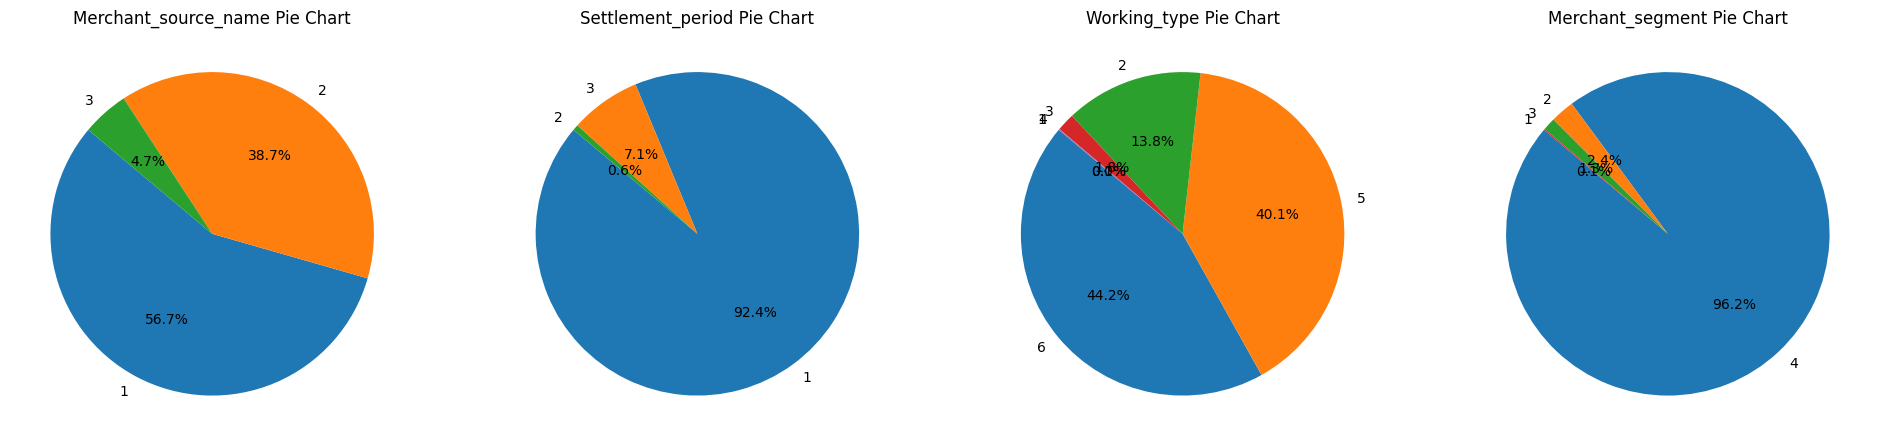

In [22]:
columns_pie = ["merchant_source_name", "settlement_period", "working_type", "merchant_segment"]
draw_pie(df, columns_pie)

- İş yerleri genellikle 1 ve 2. kaynaktan sisteme katılmış olup 3. kaynağı çok tercih etmemişlerdir. (merchant_source_name)
- İş yerlerinin hak ediş sıklığı büyük çoğunlukla 1 iken geri kalan kısmın çoğu 3 adet sıklığa aittir. 2 adet sıklık nedense çok az görülmüştür.(settlement_period)
- İş yerleri büyük oranda 5 ve 6. tiplere aitken 2 numaralı tipte belirli bir yüzdeye sahiptir. Ancak 1, 3 ve 4. iş yeri tipi neredeyse görülmemektedir.(working_type)
- İş yerleri iyzico içerisinde çok büyük oranda 4. segmente ait iken 1, 2 ve 3. numaralı segmentlere oldukça az rastlanılmıştır.(merchant_segment)

In [23]:
df["type_dataframe"] = "train"
df_sub["type_dataframe"] = "submission"

df_sub = df_sub.sort_values(by = ["year", "month"], ascending = [True, True]).reset_index(drop=True)

# EDA

Bizim sistemimizdeki özelliklerin hepsi kategoriktir. Bizde kategoriler arasında **net_payment_count** özelliği için bir fark olup olmadığını anlamak istiyoruz. Bunun için birkaç istatistiki yöntem bulunmaktadır. Biliyoruz ki **net_payment_count özelliği normal dağılıma sahip değildir**. Dolayısıyla normal dağılımı varsayan testleri eleyeceğiz. Biz **Kruskal-Wallis test** yöntemini uygulayacağız.

Bu yöntem;
- **Parametrik olmayan bir bir yöntemdir ve farklı grupların medyanları arasında istatistiksel olarak anlamlı farklılıklar olup olmadığını belirlemek için kullanılır.**


                                                        Null Hypothesis (H0): Grupların medyanları birbirine eşittir.

                                                        Alternative Hypothesis (H1): En azından bir grup farklı medyan değerine sahiptir.

P-değerinin yorumlanması:

- p-değeri < 0,05: Sıfır hipotezini reddedersiniz. Bu, en az bir grubun farklı bir medyana sahip olduğu sonucuna varmak için kanıt olduğunu gösterir.

- p-değeri >= 0,05: Sıfır hipotezini reddedemezsiniz. Bu, gruplar arasında ortanca farklılıkları olduğu sonucuna varmak için yeterli kanıt olmadığını gösterir.

**Kruskal-Wallis testi**, iki veya daha fazla grubun medyanlarını karşılaştırmak için kullanılan istatistiksel testtir. Gruplar arasında anlamlı farklılıklar olup olmadığını belirlemek için kullanılır. Testin anlamlı olması, grupların ortalamaları arasında bir fark olduğunu gösterir, ancak hangi grupların birbirinden önemli ölçüde farklı olduğunu söylemez.



İşte bu noktada **Nemenyi testi** devreye girer. Hangi grup çiftlerinin birbirinden önemli ölçüde farklı olduğunu belirlemek için kullanılan bir çoklu karşılaştırma testidir. "Kritik fark grafiği" adı verilen ve her bir grup çiftinin ortalamaları arasındaki farkı bir "kritik fark" çizgisiyle birlikte gösteren bir grafik oluşturur. Bir grup çiftinin ortalamaları arasındaki fark kritik farktan büyükse, grupların önemli ölçüde farklı olduğu kabul edilir.



Genel olarak, **Nemenyi testi**, ilk **Kruskal-Wallis testi** yapıldıktan sonra hangi grupların birbirinden önemli ölçüde farklı olduğunu belirlemek için yararlı bir araçtır. İstatistiksel analizinizin sonuçlarını anlamanıza ve verilerinizden anlamlı sonuçlar çıkarmanıza yardımcı olabilir.

## net_payment_count feature

In [24]:
# Check value counts of net_payment_count feature
df["net_payment_count"].value_counts()[:30]

net_payment_count
3     66001
4     51324
5     26191
6     23512
7     10754
8      8498
10     8258
9      6998
13     5139
11     4549
12     3985
16     3396
14     2970
15     2687
20     2441
17     2144
18     1943
23     1891
19     1753
26     1518
21     1447
22     1346
30     1205
24     1156
25     1132
33     1062
27      967
28      904
29      877
36      869
Name: count, dtype: int64

- İşletmelerin çoğu ayda 3 ten 10'a kadar net işlem yapıyor

## merchant_id feature

In [25]:
#Get multiple visible id values
non_colds = df["merchant_id"].value_counts().reset_index()
non_colds = non_colds[non_colds['count'] > 1]
non_colds = non_colds["merchant_id"].unique()

#Describe dataframe which has multiple visible id values
df.loc[df["merchant_id"].isin(non_colds), "net_payment_count"].describe()

count    2.857000e+05
mean     4.231792e+02
std      1.092309e+04
min     -1.433000e+03
25%      4.000000e+00
50%      6.000000e+00
75%      1.500000e+01
max      1.160429e+06
Name: net_payment_count, dtype: float64

In [26]:
#Describe dataframe which has once id values
df.loc[~df["merchant_id"].isin(non_colds), "net_payment_count"].describe()

count    5442.000000
mean        6.153069
std        93.737702
min        -1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max      5475.000000
Name: net_payment_count, dtype: float64

- Sadece bir kez görünen kullanıcılar ile birden çok görünen kullanıcıların eğilimlerinin farklı olduğu görülüyor.
- Birden fazla görünen kullanıcılarda standart sapma ve ortalama değerleri, bir kere görünen kullanıcılara kıyasla oldukça düşüktür. Ancak %25, %50 ve %75'lik sınır değerleri birbirine yakındır. Outlier değerlerin genellikle bir kere görünen kullanıcılarda gözüktüğü söylenebilir. 

### Companies suspending operations in Iyzico

İyzico'ya kayıt yaptırdıktan sonra iyzico'daki işlemlerine ara vermiş şirketlerin net işlem sayılarını analiz edelim.

In [27]:
df["month_after_starting"] = (df["year"] - 2020) * 12 + df["month"]
df["count_ofbreak_oniyzico"] = df.groupby("merchant_id")["month_after_starting"].diff().fillna(1) - 1

In [28]:
df["count_ofbreak_oniyzico"].value_counts()

count_ofbreak_oniyzico
0.0     254692
1.0      16945
2.0       6864
3.0       3704
4.0       2247
5.0       1591
6.0       1078
7.0        830
8.0        607
9.0        511
10.0       353
11.0       296
12.0       219
14.0       154
13.0       151
15.0       143
16.0       111
17.0        92
18.0        74
19.0        68
20.0        60
21.0        53
22.0        45
24.0        40
25.0        40
23.0        30
27.0        27
28.0        19
26.0        17
29.0        17
30.0        11
33.0        10
31.0        10
32.0         7
35.0         7
34.0         7
38.0         6
39.0         2
37.0         2
36.0         2
Name: count, dtype: int64

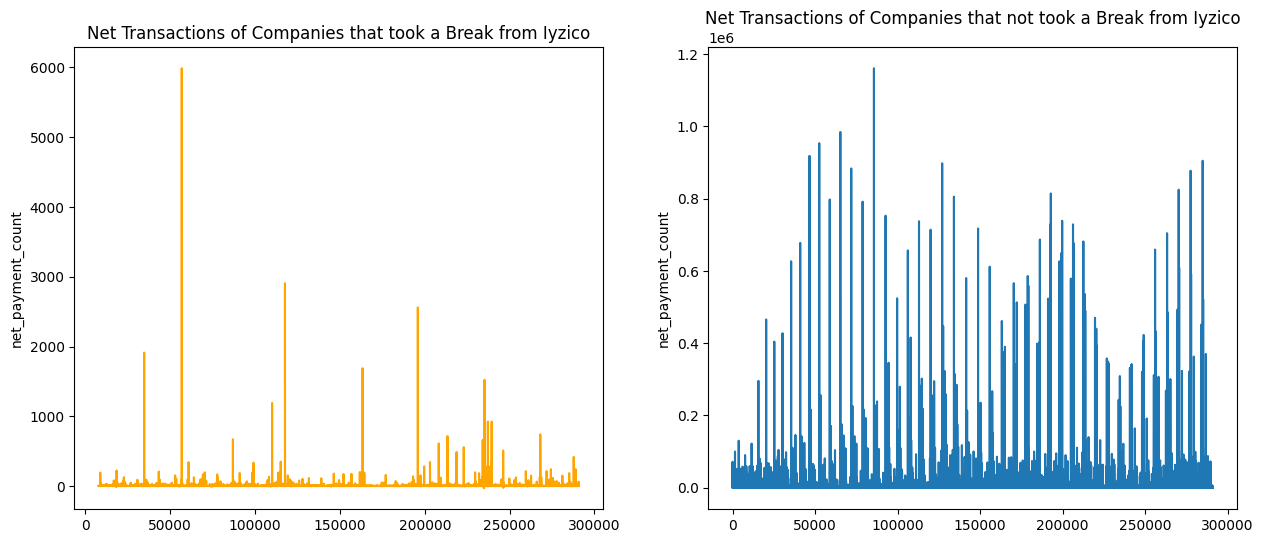

In [29]:
df_break = df[df["count_ofbreak_oniyzico"] != 0].copy()
df_notbreak = df[df["count_ofbreak_oniyzico"] == 0].copy()
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize = (15,6))
sns.lineplot(df_break["net_payment_count"],ax = ax[0],  color = "orange")
sns.lineplot(df_notbreak["net_payment_count"], ax = ax[1])

ax[0].set_title("Net Transactions of Companies that took a Break from Iyzico")
ax[1].set_title("Net Transactions of Companies that not took a Break from Iyzico")

plt.show()

Görüldüğü üzere İyzico üzerinde işlemlerine ara vermiş şirketlerin net işlem sayısı, diğer şirketlere kıyasla oldukça azdır.

In [30]:
df = df.drop(["month_after_starting", "count_ofbreak_oniyzico"], axis = 1)

### Finding companies with seasonal entries

In [31]:
"""df_ = df.groupby(['merchant_id', 'count_ofbreak_oniyzico']).size().reset_index(name='count').copy()
df_ = df_[(df_["count"] > 1) & (df_["count_ofbreak_oniyzico"] != 0)]
df_.head()"""

'df_ = df.groupby([\'merchant_id\', \'count_ofbreak_oniyzico\']).size().reset_index(name=\'count\').copy()\ndf_ = df_[(df_["count"] > 1) & (df_["count_ofbreak_oniyzico"] != 0)]\ndf_.head()'

## merchant_source_name feature

In [32]:
#Separating the dataframe according to merchant sources
df_msm1 = df[df["merchant_source_name"] == 1]
df_msm2 = df[df["merchant_source_name"] == 2]
df_msm3 = df[df["merchant_source_name"] == 3]
#Describe dataframe with merchant source number 1
df_msm1["net_payment_count"].describe()

count    164996.000000
mean        220.254976
std        7337.129128
min        -830.000000
25%           4.000000
50%           5.000000
75%          12.000000
max      904587.000000
Name: net_payment_count, dtype: float64

In [33]:
#Describe dataframe with merchant source number 2
df_msm2["net_payment_count"].describe()

count    112541.000000
mean         42.945149
std         481.913535
min        -112.000000
25%           4.000000
50%           6.000000
75%          13.000000
max       78033.000000
Name: net_payment_count, dtype: float64

In [34]:
#Describe dataframe with merchant source number 3
df_msm3["net_payment_count"].describe()

count    1.360500e+04
mean     5.862661e+03
std      4.265764e+04
min     -1.433000e+03
25%      9.000000e+00
50%      1.060000e+02
75%      1.155000e+03
max      1.160429e+06
Name: net_payment_count, dtype: float64

- **Ortalama değerleri olarak karşılaştırıldığında;** 3 numaralı kaynaktan İyzicoya katılan kurumların ortalaması diğerlerine göre oldukça yüksektir. En düşük ortalamaya ise 2 numaralı kaynaktan İyzicoya katılan kurumlar sahiptir.
- **Standart sapma değerleri olarak karşılaştırıldığında;** 3 numaralı kaynaktan İyzicoya katılan kurumların değişkenliği diğerlerine göre oldukça yüksektir. En az değişkenliğe ise 2 numaralı kaynaktan İyzicoya katılan kurumlar sahiptir.
- **%25 aralığa göre karşılaştırıldığında;** 1 ve 2 numaralı kaynaklar birbirinini aynısıdır. Ancak 3 numaralı kaynak yine en büyük değere sahiptir.
- **%50 aralığa göre karşılaştırıldığında;** 1 ve 2 numaralı kaynaklar birbirine çok yakındır. Ancak 3 numaralı kaynak yine en büyük değere sahiptir.
- **%75 aralığa göre karşılaştırıldığında;** 1 ve 2 numaralı kaynaklar birbirine çok yakındır. Ancak 3 numaralı kaynak yine en büyük değere sahiptir.
- En küçük ve En büyük değerler ise 3 numaralı kaynaktan İyzicoya katılan kurumlara aittir. 

Dolayısıyla 3 numaralı kaynaktan İyzicoya katılan kurumlar oldukça değişkenliğe sahiptir ve outlier değerlerin çoğu 3 numaralı kaynağa aittir diyebiliriz.


In [35]:
conduct_kruskal_wallis_test(df, "merchant_source_name", "net_payment_count")

Kruskal-Wallis p-value: 0.0
En azından bir grup farklı medyan değerine sahiptir


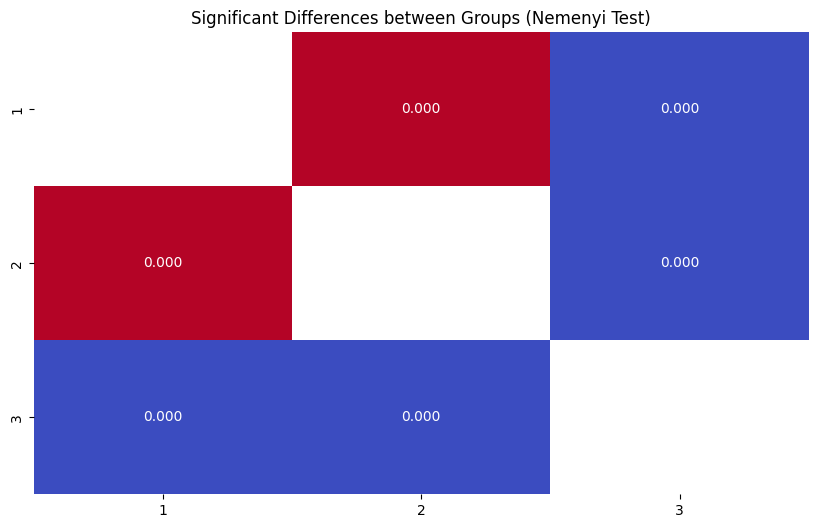

In [36]:
plot_nemenyi_posthoc_test(df, "merchant_source_name", "net_payment_count")

Nemenyi testine göre bütün gruplar birbirinden anlamlı ölçüde farklılık göstermektedir.

## settlement_period feature

In [37]:
#Separating the dataframe according to settlement period
df_sp1 = df[df["settlement_period"] == 1]
df_sp2 = df[df["settlement_period"] == 2]
df_sp3 = df[df["settlement_period"] == 3]
#Describe dataframe with settlement period number 1
df_sp1["net_payment_count"].describe()

count    268906.000000
mean         69.328234
std        1250.412774
min       -1433.000000
25%           4.000000
50%           5.000000
75%          12.000000
max      195879.000000
Name: net_payment_count, dtype: float64

In [38]:
#Describe dataframe with settlement period number 2
df_sp2["net_payment_count"].describe()

count      1683.000000
mean      19449.964349
std       70261.469809
min         -12.000000
25%          17.000000
50%         367.000000
75%        9540.000000
max      904587.000000
Name: net_payment_count, dtype: float64

In [39]:
#Describe dataframe with settlement period number 3
df_sp3["net_payment_count"].describe()

count    2.055300e+04
mean     3.384358e+03
std      3.455618e+04
min     -5.640000e+02
25%      5.000000e+00
50%      2.700000e+01
75%      2.780000e+02
max      1.160429e+06
Name: net_payment_count, dtype: float64

- **Ortalama değerleri olarak karşılaştırıldığında;** Hak ediş sıklığı 2 olan kurumların ortalaması diğerlerine göre oldukça yüksektir. En düşük ortalamaya ise Hak ediş sıklığı 1 olan kurumlar sahiptir.
- **Standart sapma değerleri olarak karşılaştırıldığında;** Hak ediş sıklığı 3 olan kurumların değişkenliği diğerlerine göre oldukça yüksektir.En az değişkenliğe ise Hak ediş sıklığı 1 olan kurumlar sahiptir.
- **%25 aralığa göre karşılaştırıldığında;** 1 ve 3 adet hak edişe sahip kurumların değerleri birbirine oldukça yakındır. Ancak 2 adet hak edişe sahip kurumların değeri yüksektir.
- **%50 aralığa göre karşılaştırıldığında;** Hak ediş sıklığı 2 olan kurumların değeri diğerlerine göre oldukça yüksektir. En düşük değere ise Hak ediş sıklığı 1 olan kurumlar sahiptir.
- **%75 aralığa göre karşılaştırıldığında;** Hak ediş sıklığı 2 olan kurumların değeri diğerlerine göre oldukça yüksektir. En düşük değere ise Hak ediş sıklığı 1 olan kurumlar sahiptir.
- En küçük değere Hak ediş sıklığı 1 olan kurumlar sahiptir.
- En büyük değre Hak ediş sıklığı 3 olan kurumlar sahiptir.


1 adet hak ediş sıklığına sahip olan kurumların; %25 ile %75 aralık değerleri arasındaki fark oldukça azdır. Bu da  dengeli değerlere sahip olduğunu gösterir. Buna rağmen standart sapması ortalamaya göre oldukça fazladır. Bu da outlier değerlerin değişkenliği oldukça etkilediğini göstermektedir.

2 adet hak ediş sıklığına sahip olan kurumların; %25 ile %75 aralık değerleri arasındaki fark oldukça fazladır. Bu da dengeli değerlere sahip olmadığını gösterir. Ortalaması ve Standart sapması  oldukça fazladır. Bu da büyük değerlerin genelde bu kurumlarda olduğunu göstermektedir. 

3 adet hak ediş sıklığına sahip olan kurumların; %25 ile %75 aralık değerleri arasındaki fark ne çok fazla ne de çok azdır. Bu da görece dengeli değerlere sahip olduğunu gösterir. En büyük değere bu kurumlardan birisi sahip olmuştur.

In [40]:
conduct_kruskal_wallis_test(df, "settlement_period", "net_payment_count")

Kruskal-Wallis p-value: 0.0
En azından bir grup farklı medyan değerine sahiptir


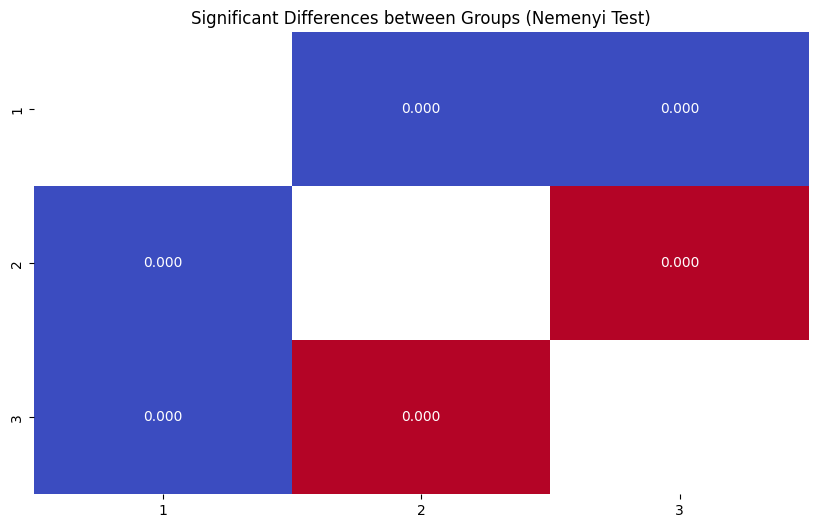

In [41]:
plot_nemenyi_posthoc_test(df, "settlement_period", "net_payment_count")

Nemenyi testine göre bütün gruplar birbirinden anlamlı ölçüde farklılık göstermektedir.

## working_type feature

In [42]:
#Separating the dataframe according to working type
df_wt1 = df[df["working_type"] == 1]
df_wt2 = df[df["working_type"] == 2]
df_wt3 = df[df["working_type"] == 3]
df_wt4 = df[df["working_type"] == 4]
df_wt5 = df[df["working_type"] == 5]
df_wt6 = df[df["working_type"] == 6]
#Describe dataframe with working type number 1
df_wt1["net_payment_count"].describe()

count    64.000000
mean     12.359375
std      18.255129
min       3.000000
25%       3.750000
50%       4.500000
75%       6.000000
max      81.000000
Name: net_payment_count, dtype: float64

In [43]:
#Describe dataframe with working type number 2
df_wt2["net_payment_count"].describe()

count    4.007100e+04
mean     1.394785e+03
std      2.271250e+04
min     -1.433000e+03
25%      4.000000e+00
50%      9.000000e+00
75%      4.900000e+01
max      1.160429e+06
Name: net_payment_count, dtype: float64

In [44]:
#Describe dataframe with working type number 3
df_wt3["net_payment_count"].describe()

count    5204.000000
mean        5.950423
std        11.947167
min        -5.000000
25%         3.000000
50%         4.000000
75%         5.000000
max       510.000000
Name: net_payment_count, dtype: float64

In [45]:
#Describe dataframe with working type number 4
df_wt4["net_payment_count"].describe()

count    255.000000
mean      16.066667
std       34.851873
min        3.000000
25%        4.000000
50%        5.000000
75%       12.000000
max      351.000000
Name: net_payment_count, dtype: float64

In [46]:
#Describe dataframe with working type number 5
df_wt5["net_payment_count"].describe()

count    116793.000000
mean        527.142449
std       10690.612940
min        -139.000000
25%           4.000000
50%           6.000000
75%          16.000000
max      904587.000000
Name: net_payment_count, dtype: float64

In [47]:
#Describe dataframe with working type number 6
df_wt6["net_payment_count"].describe()

count    128755.000000
mean         26.740398
std         279.682083
min         -22.000000
25%           3.000000
50%           5.000000
75%          11.000000
max       27664.000000
Name: net_payment_count, dtype: float64

- **1,3 ve 4 numaralı iş yeri tipine sahip kurumların** yüzdesel olarak sayısı oldukça azdır ve bu kurumlarda değişkenlik ve ortalama değerleri de diğerlerine göre oldukça düşüktür. Dolayısıyla bu kurumlarda dengeli değerler görülmüştür. Bu tip kurumları aşağıda yapacağım kıyaslamaya dahil etmeyeceğim
- **Ortalama değerleri kıyaslandığında;** En yüksek ortalamaya 2 numaralı iş yeri tipi kurumlar sahip iken, en düşük ortalamaya 6 numaralı iş yeri tipi kurumlar sahiptir.
- **Standart sapma değerleri kıyaslandığında;** En büyük değişkenliğe 2 numaralı iş yeri tipi kurumlar sahip iken, en az değişkenliğe 6 numaralı iş yeri tipi kurumlar sahiptir.
- **%25 ve %50 aralığa göre kıyaslandığında;** Bütün iş yeri tipleri birbirine yakın değerlere sahiptir.
- **%75 aralığa göre kıyaslandığında;** En yüksek aralık sınır değerine 2 numaralı kurumlar sahip iken, 5 ve 6 numaralı kurumların aralık sınır değerleri birbirine oldukça yakındır.
- En küçük ve en büyük değere 2 numaralı kurumlar sahiptir.

Bütün bu analizlere baktığımızda **2 numaralı iş yeri tipi kurumlarda ortalama ve standart sapma değerleri oldukça yüksektir. En büyük ve küçük değerlere sahiptir. Buda bilinmezliğin, değişkenliğin en fazla 2 numaralı iş yeri tipi kurumlarda olduğunu göstermektedir.**

In [48]:
conduct_kruskal_wallis_test(df, "working_type", "net_payment_count")

Kruskal-Wallis p-value: 0.0
En azından bir grup farklı medyan değerine sahiptir


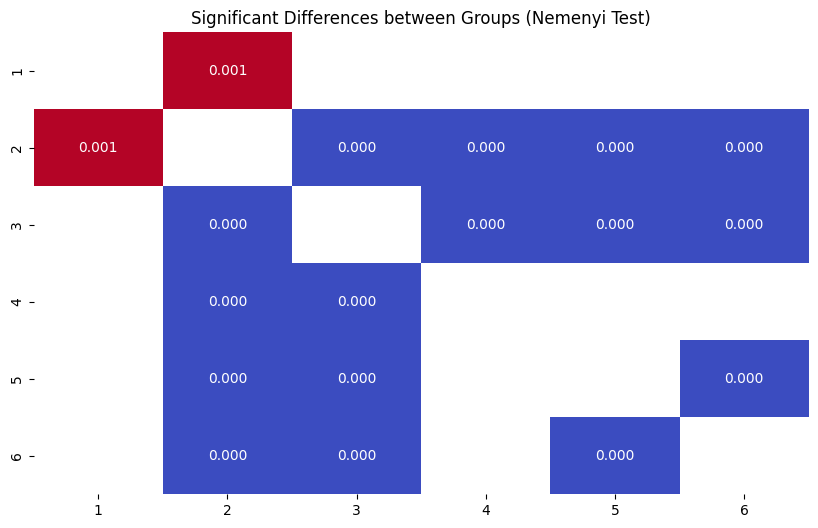

In [49]:
plot_nemenyi_posthoc_test(df, "working_type", "net_payment_count")

- **1 numaralı grup, 2 numaralı grup** ile anlamlı farklılığa sahip olup diğer gruplar ile bu farklılığı göstermemektedir. Sayı olarakta oldukça azdır. Dolayısıyla 2 numaralı hariç diğer gruplarla birleştirilebilir.
- **2 numaralı grup**, bütün gruplar ile anlamlı farklılığa sahiptir.
- **3 numaralı grup**, 1 numaralı grup hariç diğer gruplarla anlamlı farklılığa sahiptir.
- **4 numaralı grup**, 2 ve 3 numaralı grup ile anlamlı farklılığa sahiptir.
- **5 numaralı grup**, 2, 3 ve 6 numaralı grup ile anlamlı farklılığa sahiptir.
- **6 numaralı grup**, 2,3 ve 5 numaralı grup ile anlamlı farklılığa sahiptir.

Bu bilgiler ışığında 1 ve 4 numaralı grubu 5 numaralı grup ile birleştireceğim ve böylece grup sayısını azaltmış olacağım.

In [50]:
for dataframe in [df, df_sub]:
    dataframe.loc[(dataframe["working_type"] == 1) | (dataframe["working_type"] == 4), "working_type"] = 5

## mcc_id feature

Hatırlarsak **mcc_id özelliği** 1'den 197'ye kadar değerleri almıştı.

In [51]:
df["mcc_id"].value_counts()[:30]

mcc_id
42     40543
35     29872
83     13283
110    13126
24     12388
144    12258
130    10359
168     9426
80      8882
126     8336
73      7232
68      6799
5       6160
74      5976
153     5774
1       5215
85      4871
20      4687
28      4372
109     4309
169     4290
40      3639
143     3378
165     3335
162     3278
55      3243
106     3206
131     2975
190     2752
56      2582
Name: count, dtype: int64

İş yerlerinin çoğu **42, 35, 83, 110, 24, 144, 130** numaralı kategorilerde satış yapmaktadır.

In [52]:
conduct_kruskal_wallis_test(df, "mcc_id", "net_payment_count")

Kruskal-Wallis p-value: 0.0
En azından bir grup farklı medyan değerine sahiptir


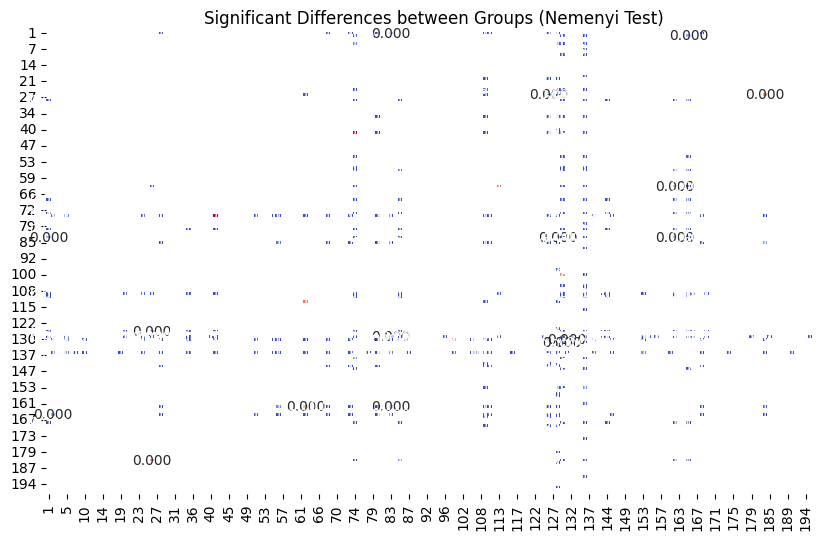

In [53]:
plot_nemenyi_posthoc_test(df, "mcc_id", "net_payment_count")

## merchant_segment feature

In [54]:
#Separating the dataframe according to merchant_segment
df_ms1 = df[df["merchant_segment"] == 1]
df_ms2 = df[df["merchant_segment"] == 2]
df_ms3 = df[df["merchant_segment"] == 3]
df_ms4 = df[df["merchant_segment"] == 4]

#Describe dataframe with merchant_segment number 1
df_ms1["net_payment_count"].describe()

count     342.000000
mean      495.871345
std       957.447098
min         3.000000
25%        54.000000
50%       154.000000
75%       543.000000
max      7461.000000
Name: net_payment_count, dtype: float64

In [55]:
#Describe dataframe with merchant_segment number 2
df_ms2["net_payment_count"].describe()

count    6.937000e+03
mean     1.343469e+04
std      6.728344e+04
min     -1.433000e+03
25%      2.400000e+01
50%      7.830000e+02
75%      3.739000e+03
max      1.160429e+06
Name: net_payment_count, dtype: float64

In [56]:
#Describe dataframe with merchant_segment number 3
df_ms3["net_payment_count"].describe()

count      3662.000000
mean       2899.031950
std       17560.415154
min        -112.000000
25%          86.250000
50%         357.000000
75%         941.250000
max      370127.000000
Name: net_payment_count, dtype: float64

In [57]:
#Describe dataframe with merchant_segment number 4
df_ms4["net_payment_count"].describe()

count    280201.000000
mean         60.504834
std        1078.905039
min        -830.000000
25%           4.000000
50%           5.000000
75%          13.000000
max       87728.000000
Name: net_payment_count, dtype: float64

In [58]:
conduct_kruskal_wallis_test(df, "merchant_segment", "net_payment_count")

Kruskal-Wallis p-value: 0.0
En azından bir grup farklı medyan değerine sahiptir


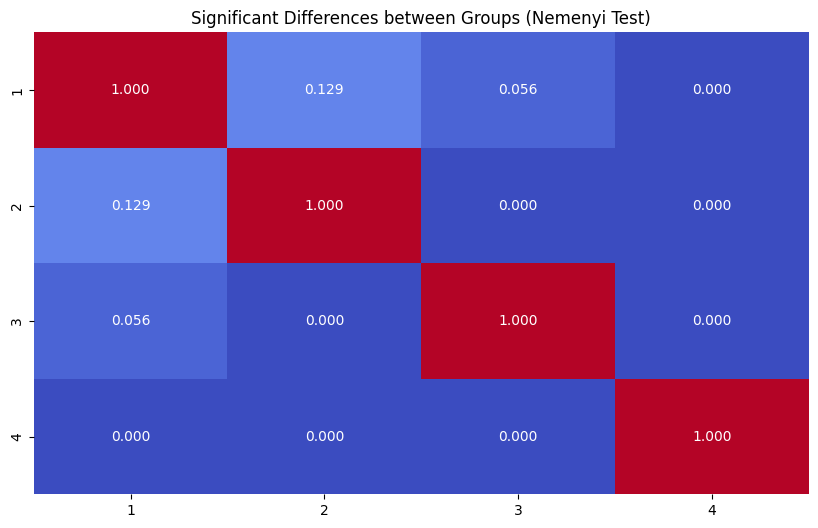

In [59]:
plot_nemenyi_posthoc_test(df, "merchant_segment", "net_payment_count", False)

- **4 numaralı segmentte bulunan kuruluşlar** diğer segmentteki kuruluşlarla net_payment_count özelliğine göre kıyaslandığında **anlamlı farklılıklar görülmektedir.**
- Ayrıca **3 numaralı segment ile 2 numaralı segment'e ait kuruluşlar arasında da** anlamlı farklılıklar görülmektedir.
- **1 numaralı segment**, 4 numaralı segment haricinde diğer segmentlerle benzer medyana sahiptir. 

Bu bilgiler ışığında 1 numaralı segment ile 2 numaralı segmenti birleştireceğim.

In [60]:
for dataframe in [df, df_sub]:
    dataframe.loc[(dataframe["merchant_segment"] == 1), "merchant_segment"] = 2

# Feature Engineering

In [61]:
if config.add_monthly_inflation_data:
    #Add monthly inflation rate
    dictionary = {
        
        2020: [1.35, 0.35, 0.57, 0.85, 1.36, 1.13, 0.58, 0.86, 0.97, 2.13, 2.30, 1.25],
        2021: [1.68, 0.91, 1.08, 1.68, 0.89, 1.94, 1.80, 1.12, 1.25, 2.39, 3.51, 13.58],
        2022: [11.10, 4.81, 5.46, 7.25, 2.98, 4.95, 2.37, 1.46, 3.08, 3.54, 2.88, 1.18],
        2023: [6.65, 3.15, 2.29, 2.39, 0.04, 3.92, 9.49, 9.09, 4.75, 3.43, 13.28, 2.93]
           
           
}   
    df, df_sub = add_monthly_values(df, df_sub, "monthly_inflation_rate", dictionary)
   
    

In [62]:
%%time
if config.add_holidays:
    for dataframe in [df, df_sub]:
        dataframe = add_count_of_holidays(dataframe) 

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.06 µs


In [63]:
if config.add_count_ofbreak_oniyzico:
    df, df_sub = add_count_ofbreak_oniyzico(df, df_sub)

In [64]:
if config.add_cumsum_merchant_id:
    df, df_sub = add_cumsum_merchant_id(df, df_sub)

In [65]:
if config.add_is_once_insysyem:
    df, df_sub = add_is_once_insysyem(df, df_sub)

In [66]:
if config.add_monthly_average_temperature_values:
    
    #Add monthly average temperature values
    dictionary = {
        
        2020: [3.3, 4.9, 9.5, 12.1, 17.6, 21.7, 25.9, 25.2, 23.9, 18.4, 9.6, 7.2],
        2021: [5.4, 6.2, 7, 13.4, 19.3, 21.8, 26.3, 26, 20.5, 15.1, 11.4, 6],
        2022: [1.8, 5, 3.7, 14.1, 16.5, 22, 24.6, 26.1, 21.5, 15.9, 11, 7.6],
        2023: [5.3, 3.4, 9.8, 12.3, 16.4, 21.4, 25.7, 27.1, 22.4, 17.1, 12.5, 8.3]
           
           
}   
    df, df_sub = add_monthly_values(df, df_sub, "monthly_average_temperature_values", dictionary)
   

In [67]:
if config.add_quarter:
    df.loc[df["month"].isin([12, 1, 2]), "quarter"]  = 1
    df.loc[df["month"].isin([3, 4, 5]), "quarter"]   = 2
    df.loc[df["month"].isin([6, 7, 8]), "quarter"]   = 3
    df.loc[df["month"].isin([9, 10, 11]), "quarter"] = 4
    
    df_sub.loc[df_sub["month"].isin([10,11]), "quarter"] = 4
    df_sub.loc[df_sub["month"].isin([12]), "quarter"]    = 1

In [68]:
if config.add_seasonality_feature:
    for dataframe in [df, df_sub]:
        dataframe["month_sin"] = np.sin(2*np.pi*dataframe.month/12)
        dataframe["month_cos"] = np.cos(2*np.pi*dataframe.month/12)

In [69]:
if config.use_one_hot_encoder_technique:
    features_one_hot_encoder = ["merchant_source_name", "settlement_period", "working_type", "merchant_segment"]
    for feature in features_one_hot_encoder:
       
        df_one_hot_encoder = pd.get_dummies(df[feature], prefix = feature, prefix_sep = "_")
        df = pd.concat([df.drop(feature, axis = 1), df_one_hot_encoder], axis = 1)
        
        df_sub_one_hot_encoder = pd.get_dummies(df_sub[feature], prefix = feature, prefix_sep = "_")
        df_sub = pd.concat([df_sub.drop(feature, axis = 1), df_sub_one_hot_encoder], axis = 1)
        

In [70]:
if config.add_oil_prices:
    #Add monthly oil prices
    dictionary = {
        
        2020: [7.11, 6.83, 5.63, 5.24, 5.55, 6.15, 6.41, 6.64, 6.59, 6.89, 6.69, 7.22],
        2021: [7.28, 7.32, 7.13, 7.15, 7.76, 7.80, 7.82, 7.82, 7.85, 7.99, 8.18, 10.98],
        2022: [13.64, 15.29, 20.48, 19.10, 22.93, 27.55, 23.76, 21.26, 19.34, 20.77, 22.84, 18.70],
        2023: [20.61, 21.14, 20.88, 22.82, 20.17, 24.42, 28.53, 38.15, 39.08, 34.20, 35.14, 33.68]
           
}   
    df, df_sub = add_monthly_values(df, df_sub, "monthly_average_oil_prices", dictionary)

Net işlem sayısına ilişkin verilerin gecikmeli değerlerini de veri setine ekliyoruz. Aşırı öğrenmenin önüne geçmek adına random_noise fonksyonu ile gecikmeli verilere rastgele gürültü ekliyoruz.

In [71]:
if config.add_lag_fetures:
    def random_noise(dataframe):
        return np.random.normal(scale=1.6, size=(len(dataframe),))


    def lag_features(dataframe, lags):
        for lag in lags:
            dataframe["net_payment_count_lag_" + str(lag)] = dataframe[["mcc_id", "net_payment_count"]].groupby("mcc_id")["net_payment_count"].transform(
                lambda x: x.shift(lag)) + random_noise(dataframe)
        return dataframe
   
    df_ = pd.concat([df, df_sub], axis = 0).copy()
    df_ = lag_features(df_, [91, 120, 152, 182, 242, 402, 542, 722])

    df = df_[df_["type_dataframe"] == "train"].copy()
    df_sub = df_[df_["type_dataframe"] == "submission"].copy()

In [72]:
if config.add_roll_mean_features:

    def roll_mean_features(dataframe, windows):
        for window in windows:
            dataframe['net_payment_count_roll_mean_' + str(window)] = dataframe.groupby(["mcc_id"])['net_payment_count']. \
                                                              transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=10).mean())
        return dataframe

    df_ = pd.concat([df, df_sub], axis = 0).copy()
    df_ = roll_mean_features(df_, [91, 120, 182, 402])

    df = df_[df_["type_dataframe"] == "train"].copy()
    df_sub = df_[df_["type_dataframe"] == "submission"].copy()


if config.add_ewm_features:
    def ewm_features(dataframe, alphas, lags):
        for alpha in alphas:
            for lag in lags:
                dataframe['net_payment_count_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                    dataframe.groupby("mcc_id")['net_payment_count'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
        return dataframe


    alphas = [0.7, 0.5]
    lags = [91, 120, 152, 182, 242, 402, 542, 722]

    df_ = pd.concat([df, df_sub], axis = 0).copy()
    df_ = ewm_features(df_, alphas, lags)

    df = df_[df_["type_dataframe"] == "train"].copy()
    df_sub = df_[df_["type_dataframe"] == "submission"].copy()

In [73]:
if config.add_statisctic_metrics:
    stat_methods = ["sum", "min", "max", "median", "mean", "std"]
    for method in stat_methods:
        df[f"{method}_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].transform(method)
    for value_mcc_id in df_sub.mcc_id.unique():
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"sum_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].sum()[value_mcc_id]
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"min_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].min()[value_mcc_id]
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"max_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].max()[value_mcc_id]
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"median_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].median()[value_mcc_id]
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"mean_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].mean()[value_mcc_id]
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"std_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].std()[value_mcc_id]
    
if config.add_quantiles:
    df["q10_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].quantile(q=0.10)
    df["q25_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].quantile(q=0.25)
    df["q75_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].quantile(q=0.75)
    df["q90_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].quantile(q=0.90)
    
    for value_mcc_id in df_sub.mcc_id.unique():
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"q10_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].quantile(q=0.10)[value_mcc_id]
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"q25_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].quantile(q=0.25)[value_mcc_id]
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"q75_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].quantile(q=0.75)[value_mcc_id]
        df_sub.loc[df_sub["mcc_id"] == value_mcc_id,f"q90_net_payment_count_by_mcc_id"] = df.groupby("mcc_id")["net_payment_count"].quantile(q=0.90)[value_mcc_id]



In [74]:
if config.add_frequences:
    df_ = pd.concat([df, df_sub], axis = 0).copy()
    merchant_segment_dict = dict(df_["merchant_segment"].value_counts(True) * 100)
    working_type_dict = dict(df_['working_type'].value_counts(True) * 100)
    settlement_period_dict = dict(df_["settlement_period"].value_counts(True) * 100)
    merchant_source_name_dict = dict(df_['merchant_source_name'].value_counts(True) * 100)
    
    df_["merchant_segment_frequence"] = df_["merchant_segment"].apply(lambda x:merchant_segment_dict[x])
    df_["working_type_frequence"] = df_["working_type"].apply(lambda x:working_type_dict[x])
    df_["settlement_period_frequence"] = df_["settlement_period"].apply(lambda x:settlement_period_dict[x])
    df_["merchant_source_name_frequence"] = df_["merchant_source_name"].apply(lambda x:merchant_source_name_dict[x])
    
    df = df_[df_["type_dataframe"] == "train"].copy()
    df_sub = df_[df_["type_dataframe"] == "submission"].copy()

In [75]:
if config.add_payU_stock:
    
    dictionary = {
        
        2020: [1088, 953, 600, 554, 634, 690, 589, 659, 625, 538, 580, 615],
        2021: [621, 590, 588, 631, 583, 599, 588, 660, 690, 707, 665, 615],
        2022: [686, 630, 580, 583, 579, 600, 588, 630, 605, 584, 545, 483],
        2023: [520, 495, 463, 452, 425, 452, 453, 545, 555, 525, 545, 485]
           
           
}   
    df, df_sub = add_monthly_values(df, df_sub, "payU_stock", dictionary)

# Modeling

In [76]:
#Specify categorical features
categorical_features = df.columns[(df.columns.str.contains("merchant_source_name|settlement_period|working_type|merchant_segment"))& \
                                 (~df.columns.str.contains("frequence"))].to_list() + \
                                 ["merchant_id", "year", "month", "mcc_id"]

if config.add_is_once_insysyem:
    categorical_features.append("is_once_insystem")

if config.add_quarter:
     categorical_features.append("quarter")

#Specify numerical features
numerical_features = [feature for feature in df.select_dtypes(include=["int", "float"]) if not feature in categorical_features and not feature == "net_payment_count"]
standart_Scaler = StandardScaler()

for dataframe in [df, df_sub]:
    dataframe[categorical_features] = dataframe[categorical_features].astype("category")
    dataframe[numerical_features] = standart_Scaler.fit_transform(dataframe[numerical_features])


## Hyperparameter Tuning


In [77]:
%%time
if config.use_hyperparameter_tuning_technique:
    from sklearn.model_selection import GridSearchCV

    X, y = df.drop("net_payment_count", axis = 1), df["net_payment_count"]
    feature_list = X.select_dtypes(include = ["int", "float"]).columns
    cv = TimeSeriesSplit(config.n_splits)
    param_catboost = {
                        "iterations": 5000,
                        "random_state": config.seed, # Set a random state for reproducibility
                        "border_count": 254,
                        "allow_writing_files": False
    }

    param_xgb = {

                        "enable_categorical":True,
                        "objective": "reg:absoluteerror",
                        "tree_method": "hist", 
                        "random_state": config.seed,  # Set a random state for reproducibility
                       
    }

    model_XGBRegressor = XGBRegressor(**param_xgb)
    model_CatBoostRegressor = CatBoostRegressor(**param_catboost)

    grid_param_xgb = {
                        "learning_rate" : [0.01, 0.05, 0.1],
                        "n_estimators"  : [100, 200, 500, 1000],
                        "max_depth"     : [6, 8, 10]

    }

    grid_param_catboost = {
                        "learning_rate" : [0.003, 0.03, 0.1],
                        "depth"     : [6, 8, 10]

    }

    for model, grid_param in [[model_XGBRegressor, grid_param_xgb], [model_CatBoostRegressor, grid_param_catboost]]:
        print(f"Model:{model}")
        print(f"Tested parameters: {grid_param}]")

        # Perform grid search with TimeSeriesSplit
        grid_search = GridSearchCV(estimator=model, param_grid=grid_param, cv=cv, scoring="neg_mean_absolute_error")

        grid_search.fit(X[feature_list], y, verbose = 500)


        # Print the best parameters and best score
        print(f"Best Parameters for {model}:", grid_search.best_params_)
        print(f"Best Score for {model}:", grid_search.best_score_)
        print("*"*120)


CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.54 µs


In [78]:
param_catboost = {
                    "one_hot_max_size": 120,
                    "cat_features": categorical_features,
                    "learning_rate": 0.1,
                    "iterations": 5000,
                    "random_state": config.seed, # Set a random state for reproducibility
                    "eval_metric": "MAE",
                    #"loss_function":"RMSE",
                    "depth": 10,
                    "border_count": 254,
                    "allow_writing_files": False,
                    "use_best_model": True,
                    "early_stopping_rounds":500
}
param_xgb = {
                    "learning_rate": 0.01,
                    "n_estimators": 200,
                    "max_depth": 6,
                    "enable_categorical":True,
                    "objective": "reg:absoluteerror",
                    "tree_method": "hist", 
                    #"device": "cuda",             # GPU acceleration
                    "random_state": config.seed,  # Set a random state for reproducibility
                    "eval_metric": "mae",
                    "early_stopping_rounds": 500
}

predicters= {
    "XGBRegressor" : XGBRegressor(**param_xgb),
    "CatBoostRegressor" : CatBoostRegressor(**param_catboost)

}

In [79]:
def create_model(
                X: pd.DataFrame,
                y: pd.Series,
                cv: TimeSeriesSplit,
                predicters: dict,
                feature_list: list
):
    mean_absolute_error_scores = list()
    models = list()
    unseen_preds = list()
    for name, model in predicters.items():
        print(f"Evaluating {name}...")
        fold_mae_scores = list()
        elapsed_time = 0
        for idx, (train_idx, val_idx) in enumerate(cv.split(X=X, y = y)):
            start_time = time.time()

            X_train = X.loc[train_idx, feature_list].copy()
            y_train = y.loc[train_idx].copy()
            X_val = X.loc[val_idx, feature_list].copy()
            y_val = y.loc[val_idx].copy()
            print(f"train_idx: {train_idx}")
            print(f"val_idx: {val_idx}")
            print(f'train: {X_train.shape}')
            print(f'val: {X_val.shape}')

            model.fit(X_train,
                        y_train,
                        eval_set=[(X_val, y_val)],

                        verbose=250)
            val_pred = model.predict(X_val)
            unseen_preds.append(val_pred)
            
            fold_mae_score = mean_absolute_error(y_true = y_val, y_pred = val_pred)
            print(f"\n{name} Model Fold {idx + 1} Mean Absolute Error:{fold_mae_score}")


            fold_mae_scores.append(fold_mae_score)

            #model_file_path = f"{name}_fold_{idx + 1}.pkl"
            #joblib.dump(model, os.path.join(config.model_path, model_file_path))
            models.append(model)

            end_time = time.time()
            elapsed = end_time - start_time
            print(f"Time to {name} Model for Fold {idx + 1}: {elapsed}")
            print("*"*120)

            elapsed_time += elapsed

        print(f"{name} model run time is : {elapsed_time} seconds")
        print(f"{name} model has a mean of Mean Absolute Error Score: {np.mean(fold_mae_scores)}")
        print("*"*120)

        mean_absolute_error_scores.append(fold_mae_scores)

    return mean_absolute_error_scores, models, unseen_preds

In [80]:
X, y = df.drop("net_payment_count", axis = 1), df["net_payment_count"]
feature_list = X.select_dtypes(include = ["int", "float", "category"]).columns
cv = TimeSeriesSplit(config.n_splits)
mean_absolute_error_scores, models, unseen_preds  = create_model(X = X,
                                                    y = y,
                                                    cv = cv,
                                                    predicters = predicters,
                                                    feature_list = feature_list)


Evaluating XGBRegressor...
train_idx: [    0     1     2 ... 48524 48525 48526]
val_idx: [48527 48528 48529 ... 97047 97048 97049]
train: (48527, 28)
val: (48523, 28)
[0]	validation_0-mae:360.64900
[199]	validation_0-mae:332.04199

XGBRegressor Model Fold 1 Mean Absolute Error:332.20793559465164
Time to XGBRegressor Model for Fold 1: 15.282742500305176
************************************************************************************************************************
train_idx: [    0     1     2 ... 97047 97048 97049]
val_idx: [ 97050  97051  97052 ... 145570 145571 145572]
train: (97050, 28)
val: (48523, 28)
[0]	validation_0-mae:401.64186
[199]	validation_0-mae:372.88090

XGBRegressor Model Fold 2 Mean Absolute Error:372.8809046002622
Time to XGBRegressor Model for Fold 2: 20.533008813858032
************************************************************************************************************************
train_idx: [     0      1      2 ... 145570 145571 145572]
val_idx: [1

## XGBRegressor

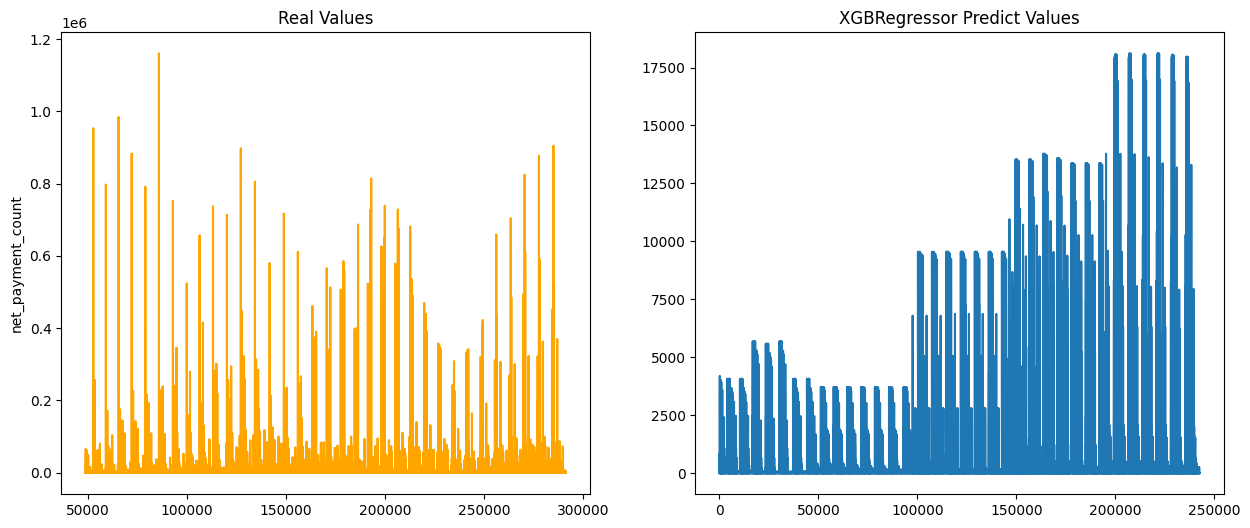

In [81]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))

sns.lineplot(df.loc[48527:,"net_payment_count"], color = "orange", ax = ax[0])
sns.lineplot(np.array(unseen_preds[:5]).flatten(), ax = ax[1])

ax[0].set_title("Real Values")
ax[1].set_title("XGBRegressor Predict Values")
plt.show()

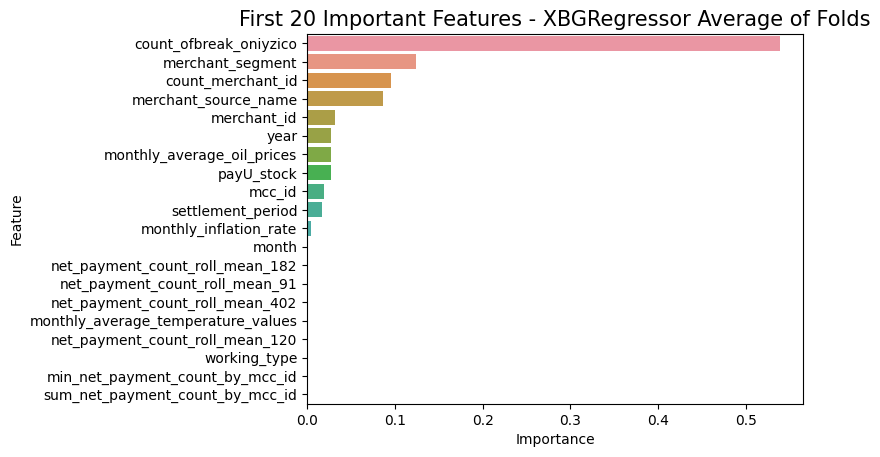

In [82]:
importances = [model.feature_importances_ for model in models[:5]]

f_importance = pd.concat([pd.Series(feature_list,name='Feature'),
                          pd.Series(np.mean(importances,axis=0),name="Importance")],
                         axis=1).sort_values(by='Importance',
                                             ascending=False)

sns.barplot(f_importance[:20],x='Importance',y='Feature')
plt.title("First 20 Important Features - XBGRegressor Average of Folds", fontsize = 15)

plt.show()

In [83]:
xgb_worst_20_features = f_importance[-20:]["Feature"].to_list()

## CatBoostRegressor

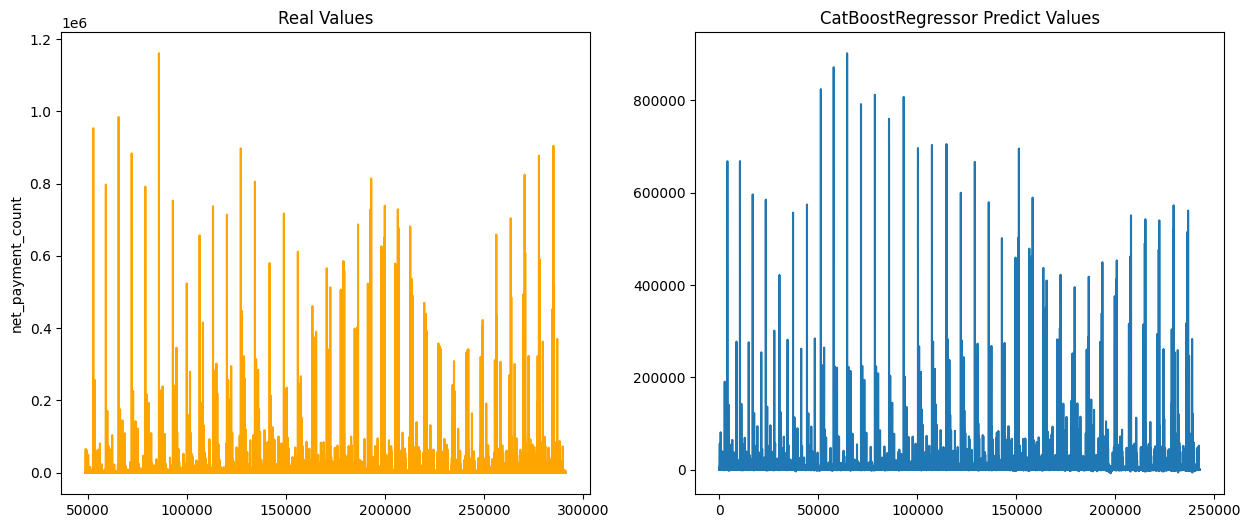

In [84]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))

sns.lineplot(df.loc[48527:,"net_payment_count"], color = "orange", ax = ax[0])
sns.lineplot(np.array(unseen_preds[5:10]).flatten(), ax = ax[1])

ax[0].set_title("Real Values")
ax[1].set_title("CatBoostRegressor Predict Values")
plt.show()

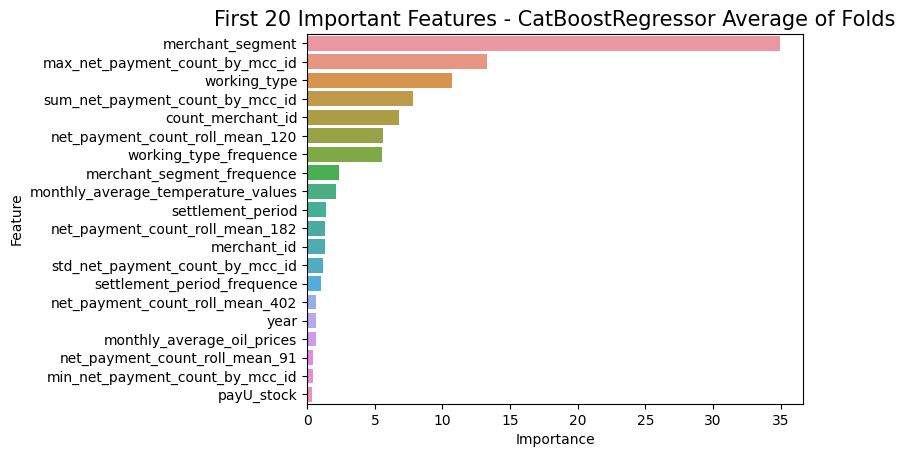

In [85]:
importances = [model.feature_importances_ for model in models[5:10]]

f_importance = pd.concat([pd.Series(feature_list,name='Feature'),
                          pd.Series(np.mean(importances,axis=0),name="Importance")],
                         axis=1).sort_values(by='Importance',
                                             ascending=False)

sns.barplot(f_importance[:20],x='Importance',y='Feature')
plt.title("First 20 Important Features - CatBoostRegressor Average of Folds", fontsize = 15)

plt.show()

In [86]:
cat_worst_20_features = f_importance[-20:]["Feature"].to_list()
common_worst_features = [wf for wf in xgb_worst_20_features if wf in cat_worst_20_features]
common_worst_features

['mcc_id',
 'settlement_period',
 'monthly_inflation_rate',
 'month',
 'net_payment_count_roll_mean_182',
 'net_payment_count_roll_mean_91',
 'net_payment_count_roll_mean_402',
 'monthly_average_temperature_values',
 'min_net_payment_count_by_mcc_id',
 'median_net_payment_count_by_mcc_id',
 'std_net_payment_count_by_mcc_id',
 'mean_net_payment_count_by_mcc_id',
 'settlement_period_frequence',
 'merchant_source_name_frequence']

In [87]:
df_sub["id"] = df_sub["year"].astype(str) + df_sub["month"].astype(str) + "merchant_" + df_sub["merchant_id"].astype(str)

model_sub = models[9] #Fold 5 of CatBoostRegressor
preds_sub = model_sub.predict(df_sub[feature_list])
df_sub["net_payment_count"] = preds_sub

a = pd.read_csv(config.dir_sub)
submission = pd.merge(a["id"],df_sub[["id", "net_payment_count"]], on = "id").set_index("id")
submission.to_csv("submission.csv")